In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,roc_auc_score


In [95]:
df = pd.read_table('Prenoms.csv',encoding = "ISO-8859-1")

Les données ne sont pas lues correctement, nous allons y remédier

In [96]:
df

,01_prenom;02_genre;03_langage;04_fréquence
0,aaliyah;f;english (modern);0
1,aapeli;m;finnish;0
2,aapo;m;finnish;0
3,"aaren;m,f;english;0"
4,aarne;m;finnish;0
...,...
11622,zvi;m;jewish;0.10
11623,zvonimir;m;croatian;0
11624,zvonimira;f;croatian;0
11625,zvonko;m;croatian;0


In [97]:
df= df['01_prenom;02_genre;03_langage;04_fréquence'].apply(lambda x:x.split(';'))

In [98]:
df = pd.DataFrame(list(df),columns=['prenom','genre','langage','fréquence'])

In [99]:
df

,prenom,genre,langage,fréquence
0,aaliyah,f,english (modern),0
1,aapeli,m,finnish,0
2,aapo,m,finnish,0
3,aaren,"m,f",english,0
4,aarne,m,finnish,0
...,...,...,...,...
11622,zvi,m,jewish,0.10
11623,zvonimir,m,croatian,0
11624,zvonimira,f,croatian,0
11625,zvonko,m,croatian,0


### Description des attributs :

- 11627 prénoms
- leur sexe (m et/ou f)
- leur langage d'utilisation
- leur fréquence par million d'occurences dans notre Frantext (les textes de Frantext publiés après 1950 interrogés en avril 2000 ce qui constitue un corpus de 31,39 millions de mots). 


On fait en sorte de n'avoir que les prénoms et leur genre dans notre dataset

In [100]:
df = df.drop(['langage'],axis=1)

In [101]:
df

,prenom,genre,fréquence
0,aaliyah,f,0
1,aapeli,m,0
2,aapo,m,0
3,aaren,"m,f",0
4,aarne,m,0
...,...,...,...
11622,zvi,m,0.10
11623,zvonimir,m,0
11624,zvonimira,f,0
11625,zvonko,m,0


On vérifie si aucune valeur ne manque

In [102]:
df.isnull().isnull().sum()

prenom       0
genre        0
fréquence    0
dtype: int64

In [103]:
df.genre.unique()

array(['f', 'm', 'm,f', 'f,m'], dtype=object)

In [104]:
df.drop_duplicates(subset ="prenom",
                     keep = False, inplace = True)

On transforme les genre ci-dessus en valeurs categorielles numeriques

In [105]:
# df.genre.replace({'f':0,'m':1, 'm,f':2, 'f,m':2},inplace=True)
df.genre.replace({'f':0,'m':1, 'm,f':2, 'f,m':2},inplace=True)

In [106]:
import re
# nous voulons eliminer toutes les occurence de type [prenom (chiffre)]
df['prenom'] = df['prenom'].apply(lambda x:re.sub(r' \([0-9]+\)', '', x))

In [107]:
classes_repartition = df.groupby('genre').count()
classes_repartition

,prenom,fréquence
genre,,
0,5313,5313
1,5878,5878
2,436,436


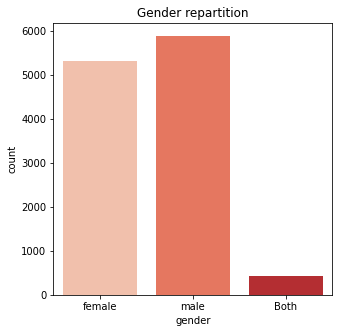

In [108]:
plt.figure(figsize=(5, 5))
sns.barplot(x=['female','male','Both'],
            y=list(classes_repartition['prenom']), palette='Reds')
plt.title('Gender repartition')
plt.xlabel('gender')
plt.ylabel('count')
plt.show()

On download notre dataframe, qu'on pourra utiliser plustard

In [109]:
df.to_csv('dataframe_names.csv')

In [110]:
CV = CountVectorizer()
DV = DictVectorizer()

def split_df(x,y,vectorizer):
    """ Splits a dataset into train/test slices, and applying the vectorizer to before returning.
    """
    X_train, X_test, y_train, y_test =  train_test_split(x,y, test_size=0.3, random_state=42)
    X_train_vector = vectorizer.fit_transform(X_train)
    X_test_vector = vectorizer.transform(X_test)
    return X_train_vector, X_test_vector, y_train, y_test,X_test

In [111]:
X_train_vector, X_test_vector, y_train, y_test,X_test= split_df(df.prenom,df.genre,CV)

In [112]:
clf = MultinomialNB()
clf.fit(X_train_vector,y_train)

MultinomialNB()

In [113]:
predictions = clf.predict(X_test_vector)

In [114]:
print(classification_report(y_test, predictions,zero_division=False))

              precision    recall  f1-score   support

           0       0.69      0.01      0.02      1586
           1       0.51      0.99      0.68      1786
           2       0.00      0.00      0.00       117

    accuracy                           0.52      3489
   macro avg       0.40      0.34      0.23      3489
weighted avg       0.58      0.52      0.36      3489



In [115]:
clf_LR = LogisticRegressionCV(cv=10,max_iter=10000)
clf_LR.fit(X_train_vector,y_train)
predictions_lr = clf_LR.predict(X_test_vector)

In [116]:
print(classification_report(y_test, predictions_lr,zero_division=False))

              precision    recall  f1-score   support

           0       0.69      0.01      0.02      1586
           1       0.51      0.99      0.68      1786
           2       0.20      0.01      0.02       117

    accuracy                           0.51      3489
   macro avg       0.47      0.34      0.24      3489
weighted avg       0.58      0.51      0.36      3489



On peut voir que nos classifiers ont de mauvais résultats l'un comme l'autre.

On peut peut emettre des hypotheses pour améliorer les résultats de nos modèls, puis tester leur veracité.

##### Hypothese 1: 

- La dernière lettre d'un prenom est trés informative quant au genre du prenom.

In [117]:
df['last_char'] = df.prenom.apply(lambda x: x[-1])

In [118]:
df

,prenom,genre,fréquence,last_char
0,aaliyah,0,0,h
1,aapeli,1,0,i
2,aapo,1,0,o
3,aaren,2,0,n
4,aarne,1,0,e
...,...,...,...,...
11622,zvi,1,0.10,i
11623,zvonimir,1,0,r
11624,zvonimira,0,0,a
11625,zvonko,1,0,o


Pour prendre en compte ce nouvel attribut, nous allons utiliser un autre vectorizer que **CountVectorizer**, car ce dernier ne nous permet pas de prendre en compte ce nouvel attribut seul.
Erreur : `ValueError: empty vocabulary; perhaps the documents only contain stop words`


Il nous faut transformer le Dataframe en dictionnaire car c'est ce que prend **DictVectorizer** en params.

In [119]:
def new__feature(prenom):
    return {"LC":prenom[-1].lower()}

# on utilise np.vectorize pour pouvoir faire passer tout nos prenoms à la fois en parametres.
vectorized_extract_feature = np.vectorize(new__feature)

In [120]:
X_ = vectorized_extract_feature(df.prenom)
X_

array([{'LC': 'h'}, {'LC': 'i'}, {'LC': 'o'}, ..., {'LC': 'a'},
       {'LC': 'o'}, {'LC': 't'}], dtype=object)

In [121]:
X_train, X_test, y_train, y_test =  train_test_split(df.prenom,df.genre, test_size=0.3, random_state=42,shuffle=True)

In [122]:
def train_test_report(algo,vectorizer,f):
    """ Evaluates the efficiency of a model according to certain metrics.

    Args:
        algo (function): the model that will be fitted and used to peedict.
        vectorizer (object): vectorize our inputs, in order to feed 'algo'.
        f (function): a function that will extract features from names according to a certain characteristics
        x (Series): names from the main dataset
        y (Series): genders of 'x'

    Returns:

    """
    X_train_vector = vectorizer.fit_transform(f(X_train))
    X_test_vector = vectorizer.transform(f(X_test))
  
    if algo.__name__ == 'LogisticRegressionCV': 
        clf =LogisticRegressionCV(cv=5,max_iter=10000)
    else : 
        clf = algo()
    clf.fit(X_train_vector,y_train)
    predictions = clf.predict(X_test_vector)
    train_preds = clf.predict(X_train_vector)
    print(60*"=")
    print(25*'-'+'test'+'-'*25)
    print(classification_report(y_test, predictions,zero_division=False))
    print(60*"=")
    print(25*'-'+'train'+'-'*25)
    print(classification_report(y_train, train_preds,zero_division=False))
    print(60*"=")


    return X_test_vector,predictions,clf
    
def filter_errors(preds,true_vals,x):
    """shows all classification errors in order to detect some patterns
    """
    gender = {0:'female',1:'male',2:'both'}
    for i,val in enumerate(true_vals):
        p =preds[i]
        if val != p:
            print('Name :',x[i],'\tThe real gender is :', gender[val],'\tits prediction is :',gender[p])
    

In [123]:
X_test_MNB,predictions,clf =train_test_report(MultinomialNB,DV,vectorized_extract_feature)

-------------------------test-------------------------
              precision    recall  f1-score   support

           0       0.82      0.67      0.74      1586
           1       0.72      0.89      0.79      1786
           2       0.00      0.00      0.00       117

    accuracy                           0.76      3489
   macro avg       0.51      0.52      0.51      3489
weighted avg       0.74      0.76      0.74      3489

-------------------------train-------------------------
              precision    recall  f1-score   support

           0       0.83      0.67      0.74      3727
           1       0.71      0.89      0.79      4092
           2       0.00      0.00      0.00       319

    accuracy                           0.75      8138
   macro avg       0.51      0.52      0.51      8138
weighted avg       0.74      0.75      0.74      8138



In [124]:
X_test_LR,predictions_LR,clf_LR =train_test_report(LogisticRegressionCV,DV,vectorized_extract_feature)

-------------------------test-------------------------
              precision    recall  f1-score   support

           0       0.82      0.67      0.74      1586
           1       0.72      0.89      0.79      1786
           2       0.00      0.00      0.00       117

    accuracy                           0.76      3489
   macro avg       0.51      0.52      0.51      3489
weighted avg       0.74      0.76      0.74      3489

-------------------------train-------------------------
              precision    recall  f1-score   support

           0       0.83      0.67      0.74      3727
           1       0.71      0.89      0.79      4092
           2       0.00      0.00      0.00       319

    accuracy                           0.75      8138
   macro avg       0.51      0.52      0.51      8138
weighted avg       0.74      0.75      0.74      8138



Notre hypothèse s'avére être trés interessante, car, on a largement augmonté les résultats des mtrics.

Par ailleurs, nos modeles semblent incapables de classifier les prénoms épicènes.

#### Hypothèse 2:

- on pourrait à présent augmonter le nombre de nos features en prenant en concidération la première lettre, et meême les deux dernières lettres en simulatané.
car il se pourrait que certains prénoms aient la même dernière lettre, mais pas la même avant denière.

- Par exemple : jackl`yn`, rael`yn`, rhos`yn`, rob`yn`, rosal`yn`, rosel`yn`, rosl`yn` etc 
ne sont que des prénoms feminins, 
parcontre des prénoms finissant par la lettre `n` en tendance à être masculins.

Essayons donc de voir quels résultats obtiendrons nous avec des features en plus suite à ces remarques.

In [125]:
filter_errors(predictions,y_test,np.array(X_test))

Name : rabab 	The real gender is : female 	its prediction is : male
Name : leigh 	The real gender is : female 	its prediction is : male
Name : anan 	The real gender is : both 	its prediction is : male
Name : ragnborg 	The real gender is : female 	its prediction is : male
Name : thanh 	The real gender is : both 	its prediction is : male
Name : amity 	The real gender is : female 	its prediction is : male
Name : scout 	The real gender is : female 	its prediction is : male
Name : junko 	The real gender is : female 	its prediction is : male
Name : janel 	The real gender is : female 	its prediction is : male
Name : bosmat 	The real gender is : female 	its prediction is : male
Name : hildur 	The real gender is : female 	its prediction is : male
Name : cairbre 	The real gender is : male 	its prediction is : female
Name : opal 	The real gender is : female 	its prediction is : male
Name : pista 	The real gender is : male 	its prediction is : female
Name : terrence 	The real gender is : male 	its

In [126]:
def new_feature_2(prenom):
    return {"FC":prenom[0].lower(),
            "LC":prenom[-1].lower(),
            "LTC":prenom[-2:]
            }
    
vectorized_extract_feature_2 = np.vectorize(new_feature_2)

In [127]:
X_2 = vectorized_extract_feature_2(df.prenom)

In [128]:
X_2

array([{'FC': 'a', 'LC': 'h', 'LTC': 'ah'},
       {'FC': 'a', 'LC': 'i', 'LTC': 'li'},
       {'FC': 'a', 'LC': 'o', 'LTC': 'po'}, ...,
       {'FC': 'z', 'LC': 'a', 'LTC': 'ra'},
       {'FC': 'z', 'LC': 'o', 'LTC': 'ko'},
       {'FC': 'z', 'LC': 't', 'LTC': 'nt'}], dtype=object)

In [129]:
X_test_MNB,predictions_MNB,clf_MNB =train_test_report(MultinomialNB,DV,vectorized_extract_feature_2)

-------------------------test-------------------------
              precision    recall  f1-score   support

           0       0.78      0.75      0.76      1586
           1       0.76      0.82      0.79      1786
           2       0.29      0.10      0.15       117

    accuracy                           0.76      3489
   macro avg       0.61      0.56      0.57      3489
weighted avg       0.75      0.76      0.76      3489

-------------------------train-------------------------
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      3727
           1       0.77      0.83      0.80      4092
           2       0.31      0.13      0.19       319

    accuracy                           0.77      8138
   macro avg       0.63      0.58      0.59      8138
weighted avg       0.76      0.77      0.77      8138



In [130]:
X_test_LR,predictions_LR,clf_LR =train_test_report(LogisticRegressionCV,DV,vectorized_extract_feature_2)

-------------------------test-------------------------
              precision    recall  f1-score   support

           0       0.76      0.79      0.77      1586
           1       0.78      0.80      0.79      1786
           2       0.17      0.01      0.02       117

    accuracy                           0.77      3489
   macro avg       0.57      0.53      0.53      3489
weighted avg       0.75      0.77      0.76      3489

-------------------------train-------------------------
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      3727
           1       0.79      0.84      0.81      4092
           2       0.60      0.03      0.05       319

    accuracy                           0.79      8138
   macro avg       0.73      0.56      0.55      8138
weighted avg       0.78      0.79      0.78      8138



In [131]:
X_test_RF,predictions_RF,clf_RF =train_test_report(RandomForestClassifier,DV,vectorized_extract_feature_2)

-------------------------test-------------------------
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1586
           1       0.77      0.78      0.77      1786
           2       0.18      0.06      0.09       117

    accuracy                           0.75      3489
   macro avg       0.56      0.54      0.54      3489
weighted avg       0.74      0.75      0.74      3489

-------------------------train-------------------------
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      3727
           1       0.87      0.88      0.88      4092
           2       0.75      0.34      0.47       319

    accuracy                           0.86      8138
   macro avg       0.83      0.70      0.74      8138
weighted avg       0.86      0.86      0.86      8138



Remarque:

- En effet, nous obtenons de meilleurs resultats.

- Mais on peut remarquer que notre dernier modele overfit déja avec 3 features, on pourrait réduire le paramêtre `max_depth`, ce qui devrait réduire ou même annuler l'overfitting.

#### Hypothese 3:
- La remarque précedente amorce notre troisième hypothèse. Si jamais on continuait à extraire des features, on risquerait d'overfitter encore plus même avec les autres modèls, car ils s'adapteront trop sur nos données de train.


In [132]:
def new_feature_3(prenom):
    return {"FC":prenom[0].lower(),
            "lCr":prenom[-1].lower(),
            "LTHC":prenom[-3:],
            "LFC":prenom[-4:],
            "LFVC":prenom[-5:],
            "LTC":prenom[-2:]
            }
    
vectorized_extract_feature_3 = np.vectorize(new_feature_3)
X_3 = vectorized_extract_feature_3(df.prenom)
X_3

array([{'FC': 'a', 'lCr': 'h', 'LTHC': 'yah', 'LFC': 'iyah', 'LFVC': 'liyah', 'LTC': 'ah'},
       {'FC': 'a', 'lCr': 'i', 'LTHC': 'eli', 'LFC': 'peli', 'LFVC': 'apeli', 'LTC': 'li'},
       {'FC': 'a', 'lCr': 'o', 'LTHC': 'apo', 'LFC': 'aapo', 'LFVC': 'aapo', 'LTC': 'po'},
       ...,
       {'FC': 'z', 'lCr': 'a', 'LTHC': 'ira', 'LFC': 'mira', 'LFVC': 'imira', 'LTC': 'ra'},
       {'FC': 'z', 'lCr': 'o', 'LTHC': 'nko', 'LFC': 'onko', 'LFVC': 'vonko', 'LTC': 'ko'},
       {'FC': 'z', 'lCr': 't', 'LTHC': 'unt', 'LFC': 'munt', 'LFVC': 'gmunt', 'LTC': 'nt'}],
      dtype=object)

In [133]:
X_test_MNB,predictions_MNB,clf_MNB =train_test_report(MultinomialNB,DV,vectorized_extract_feature_3)

-------------------------test-------------------------
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1586
           1       0.79      0.84      0.81      1786
           2       0.80      0.03      0.07       117

    accuracy                           0.79      3489
   macro avg       0.79      0.56      0.56      3489
weighted avg       0.79      0.79      0.78      3489

-------------------------train-------------------------
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      3727
           1       0.87      0.91      0.89      4092
           2       0.98      0.13      0.23       319

    accuracy                           0.87      8138
   macro avg       0.91      0.65      0.67      8138
weighted avg       0.88      0.87      0.86      8138



In [134]:
X_test_LR,predictions_LR,clf_LR =train_test_report(LogisticRegressionCV,DV,vectorized_extract_feature_3)

-------------------------test-------------------------
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1586
           1       0.79      0.86      0.83      1786
           2       0.71      0.04      0.08       117

    accuracy                           0.80      3489
   macro avg       0.77      0.57      0.57      3489
weighted avg       0.80      0.80      0.79      3489

-------------------------train-------------------------
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3727
           1       0.88      0.94      0.90      4092
           2       0.93      0.13      0.23       319

    accuracy                           0.89      8138
   macro avg       0.90      0.66      0.68      8138
weighted avg       0.89      0.89      0.88      8138



In [135]:
X_test_RF,predictions_RF,clf_RF =train_test_report(RandomForestClassifier,DV,vectorized_extract_feature_3)

-------------------------test-------------------------
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1586
           1       0.79      0.87      0.83      1786
           2       0.47      0.08      0.13       117

    accuracy                           0.80      3489
   macro avg       0.70      0.58      0.59      3489
weighted avg       0.80      0.80      0.79      3489

-------------------------train-------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3727
           1       1.00      1.00      1.00      4092
           2       1.00      0.98      0.99       319

    accuracy                           1.00      8138
   macro avg       1.00      0.99      0.99      8138
weighted avg       1.00      1.00      1.00      8138



Effectivement, nos modeles overfittent assez.